## Yelp Reviews Clustering Analysis
This notebook explores Yelp reviews with the goal of identifying hidden user groups based on the textual content of their reviews.


In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
# Import necessary libraries for text processing
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import FreqDist
from nltk import ngrams
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
# Import necessary libraries for dimensionality reduction
from sklearn.decomposition import PCA
import umap
# Import necessary libraries for clustering and text processing
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
# Import necessary libraries for  visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Initial EDA
Whats in the database? let's explore.

In [32]:
# Load the Yelp review dataset, limited to 200,000 rows for performance
# Note: json file to be downloaded from https://www.yelp.com/dataset
reviews = pd.read_json('yelp_academic_dataset_review.json', lines=True, nrows=200000)
print(reviews.shape)
reviews.head()

(200000, 9)


review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      5       1      0     1   
2      3       0      0     0   
3      5       1      0     1   
4      4       1      0     1   

                                                text                date  
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year... 2012-01-03 15:28:18  
2  Family diner. Had the buffet. Eclectic assortm... 2014-02-05 20:30:30  
3  Wow!  Yummy, different,  delicious.   Our favo... 2015-01-04 00:01:03  
4  Cute interior and owner (?) gave us tour of up... 2017-01-14 20:54:15

In [33]:
# add length of reviews
reviews['length'] = reviews['text'].apply(lambda x: len(x.split()))

In [34]:
# break down date
reviews['date'] = pd.to_datetime(reviews['date'])
reviews['year'] = reviews['date'].dt.year
reviews['month'] = reviews['date'].dt.month 
reviews['day'] = reviews['date'].dt.day

# remove date column
reviews.drop(columns=['date'], inplace=True)

In [35]:
# initial data exploration 1 - summary statistics
reviews.describe().transpose()

count         mean        std     min     25%     50%     75%  \
stars   200000.0     3.841425   1.357044     1.0     3.0     4.0     5.0   
useful  200000.0     0.901890   2.062767     0.0     0.0     0.0     1.0   
funny   200000.0     0.257635   1.002639     0.0     0.0     0.0     0.0   
cool    200000.0     0.349225   1.077559     0.0     0.0     0.0     0.0   
length  200000.0   101.296765  93.519058     1.0    41.0    73.0   129.0   
year    200000.0  2014.833300   2.439746  2005.0  2013.0  2015.0  2017.0   
month   200000.0     6.327750   3.316025     1.0     3.0     6.0     9.0   
day     200000.0    15.655795   8.806177     1.0     8.0    16.0    23.0   

           max  
stars      5.0  
useful   320.0  
funny     98.0  
cool      49.0  
length  1006.0  
year    2019.0  
month     12.0  
day       31.0

In [36]:
# initial data exploration 2 - data types and missing values
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_id    200000 non-null  object
 1   user_id      200000 non-null  object
 2   business_id  200000 non-null  object
 3   stars        200000 non-null  int64 
 4   useful       200000 non-null  int64 
 5   funny        200000 non-null  int64 
 6   cool         200000 non-null  int64 
 7   text         200000 non-null  object
 8   length       200000 non-null  int64 
 9   year         200000 non-null  int32 
 10  month        200000 non-null  int32 
 11  day          200000 non-null  int32 
dtypes: int32(3), int64(5), object(4)
memory usage: 16.0+ MB


### Date - features analysis

Let's find out the trends in reviews across time. Expectations:
- Increasing reviews count trendline from 2007 (iPhone released) to 2019 (latest year in the dataset).
- Almost no change in review langth across time.
- Most reviews are written at summer months and holiday seasons.

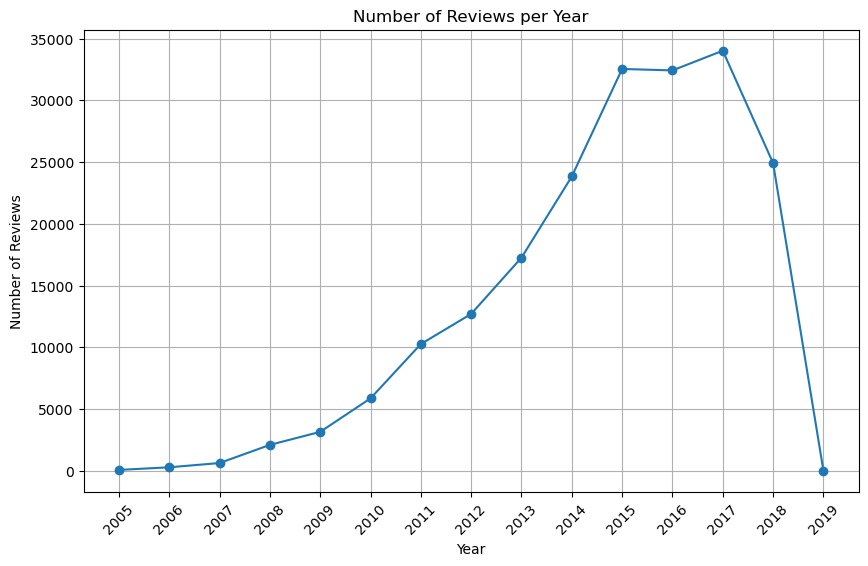

In [37]:
# time series analysis - reviews per year
reviews_per_year = reviews.groupby('year').size().reset_index(name='count')

# plotting
plt.figure(figsize=(10, 6))
plt.plot(reviews_per_year['year'], reviews_per_year['count'], marker='o')
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(reviews_per_year['year'], rotation=45)
plt.grid()
plt.show()

The chart above shows:
- A constant growth in reviews.
- Outliers years 2018-2019: the dataset must be uncomleted and cutoff arounf that time.
- We can also ignore years 2005-2007, the first years of Yelp.

In [38]:
# removing outlire years - 2005-2007 & 2018-2019
reviews = reviews[(reviews['year'] >= 2008) & (reviews['year'] <= 2017)]

# removing outlier reviews - length < 10 words
reviews = reviews[reviews['length'] >= 10]

plotting again after cleaning

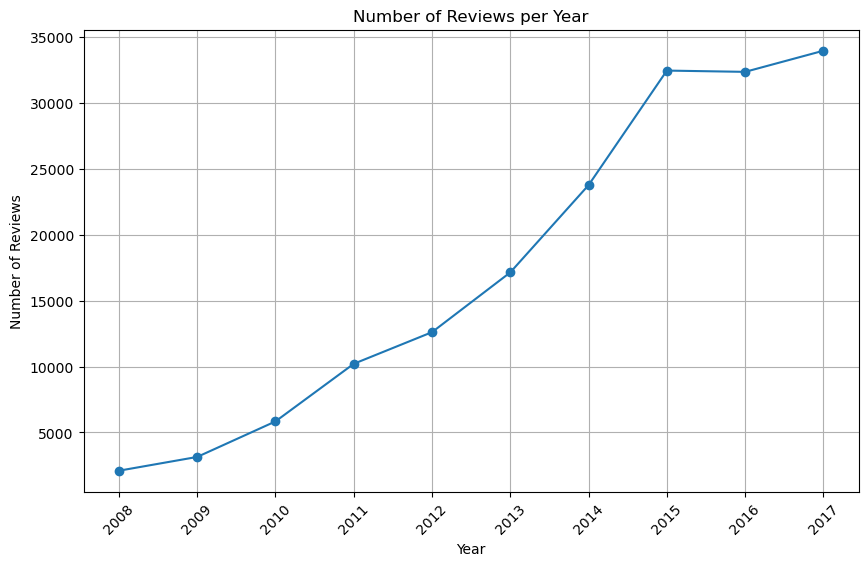

In [ ]:
# time series analysis - reviews per year
reviews_per_year = reviews.groupby('year').size().reset_index(name='count')

# plotting
plt.figure(figsize=(10, 6))
plt.plot(reviews_per_year['year'], reviews_per_year['count'], marker='o')
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(reviews_per_year['year'], rotation=45)
plt.grid()
plt.show()

Now let's see the connection between the length of the review and the year it was written on.

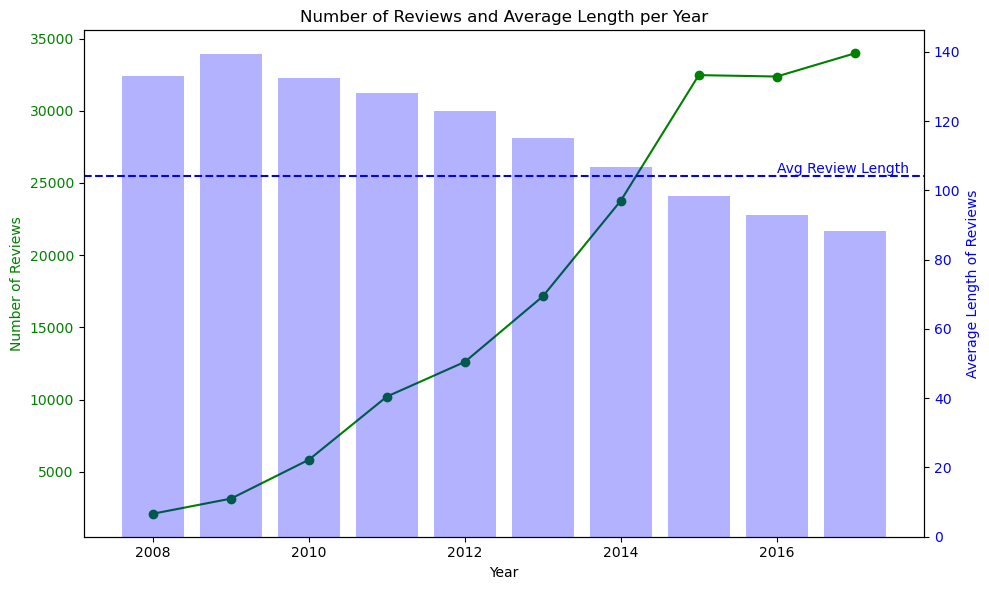

In [43]:
# length of reviews per year
reviews_length_per_year = reviews.groupby('year')['length'].mean().reset_index()

# plotting both
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
ax1.plot(reviews_per_year['year'], reviews_per_year['count'], 'g-', marker='o', label='Number of Reviews')
ax2.bar(reviews_length_per_year['year'], reviews_length_per_year['length'], color='b', alpha=0.3, label='Average Length of Reviews')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Reviews', color='g')
ax2.set_ylabel('Average Length of Reviews', color='b')
ax1.tick_params(axis='y', labelcolor='g')
ax2.tick_params(axis='y', labelcolor='b')
plt.title('Number of Reviews and Average Length per Year')
plt.axhline(y=reviews.length.mean(), color='b', linestyle='--')
plt.text(reviews_per_year['year'].iloc[-2], reviews.length.mean() + 1, f'Avg Review Length', color='b')
fig.tight_layout()
plt.show()

The chart above shows that while the amount of reviews is increasing, the avg length falls. It's shows thats with time users take less time and effort to write, thus contribute less to the community.
- If this trend continues, the reviews will become less useful and the traffic to Yelp migh decreases.
- This is an important insight - Yelp should work to stop this trend!

Now Let's take a look at the data on a monthly basis.

In [85]:
reviews.groupby(['month']).size().reset_index(name='count')

month  count
0       1  14248
1       2  12721
2       3  14547
3       4  13915
4       5  14624
5       6  14845
6       7  16742
7       8  16281
8       9  13665
9      10  15852
10     11  12886
11     12  13312

In [ ]:
# Monthly & Seasonal analysis 
reviews_per_month = reviews.groupby(['month']).size().reset_index(name='count')
reviews_per_month['season'] = reviews_per_month['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else ('Spring' if x in [3, 4, 5] else ('Summer' if x in [6, 7, 8] else 'Fall')))
reviews_per_month

month  count  season
0       1  14248  Winter
1       2  12721  Winter
2       3  14547  Spring
3       4  13915  Spring
4       5  14624  Spring
5       6  14845  Summer
6       7  16742  Summer
7       8  16281  Summer
8       9  13665    Fall
9      10  15852    Fall
10     11  12886    Fall
11     12  13312  Winter

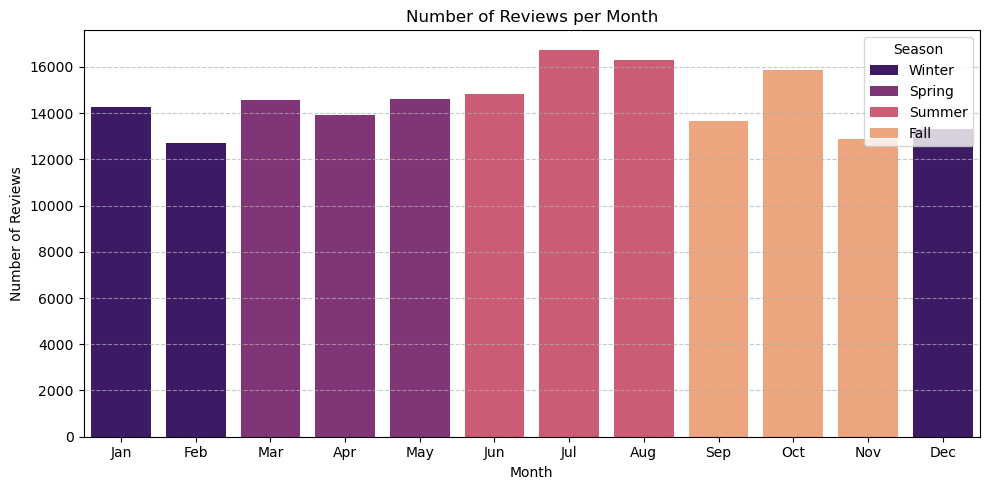

In [94]:
# plotting monthly reviews count
plt.figure(figsize=(10, 5))
sns.barplot(data=reviews_per_month, x='month', y='count', palette='magma', hue ='season')
plt.title('Number of Reviews per Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.legend(title='Season', loc='upper right')
plt.xticks(ticks=range(0, 12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The chart above shows a very vauge trend, let's normalise it to see the trend more clearly.

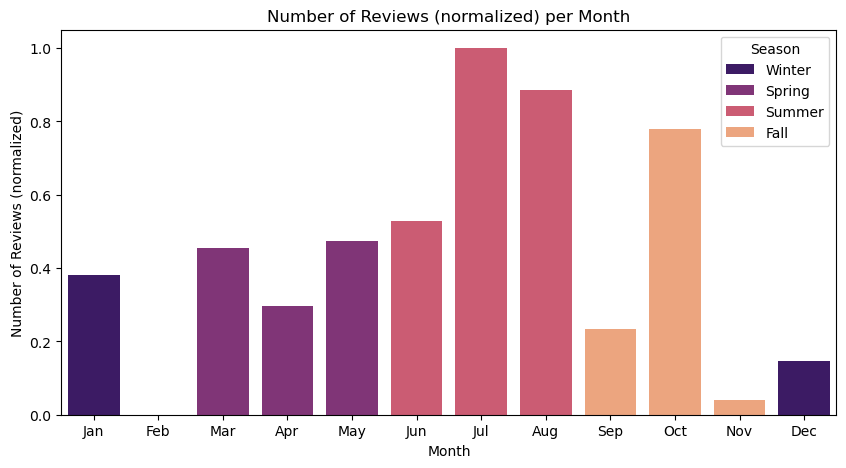

In [96]:
# Normalizing the count for better visualization
reviews_per_month['count_normalized'] = (reviews_per_month['count'] - reviews_per_month['count'].min()) / (reviews_per_month['count'].max() - reviews_per_month['count'].min())

# Monthly analysis with improved readability
plt.figure(figsize=(10, 5))
sns.barplot(data=reviews_per_month, x='month', y='count_normalized', palette='magma', hue ='season')
plt.title('Number of Reviews (normalized) per Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews (normalized)')
plt.legend(title='Season', loc='upper right')
plt.xticks(ticks=range(0, 12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.show()

The chart above shows the busiest season is Summer (as expected), there is also a small peak around US holidays (New Years, Halloween, Easter). The lowest count is on February.

There are alot more to analyse here!
- Weekends vs Weekdays
- Time analysis (Morning/Noon/Evenings)
- Review narrative across time and date

Due to time constrains, let's explore more features:

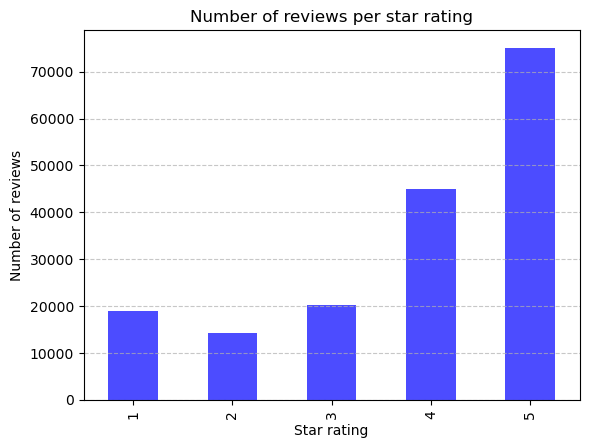

In [50]:
# Stars rating distribution
stars_reviews = reviews.value_counts('stars')
stars_reviews.sort_index().plot(kind='bar', color='blue', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Number of reviews per star rating')
plt.xlabel('Star rating')
plt.ylabel('Number of reviews')
plt.show()

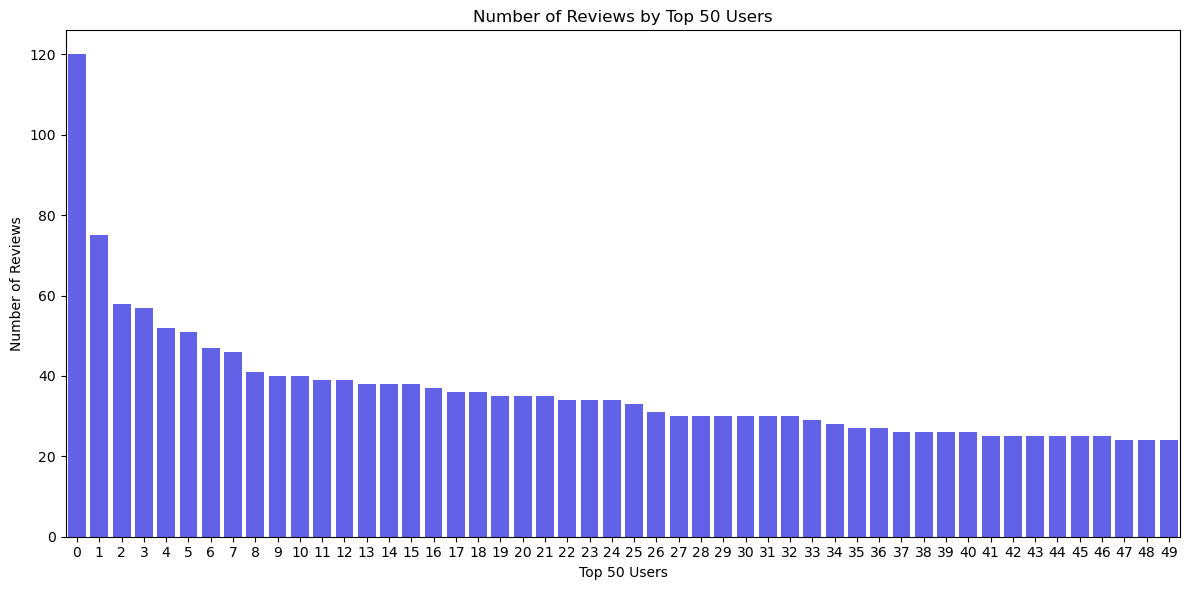

In [51]:
# How many users wrote a certain number of reviews
reviews_per_user = reviews.groupby('user_id')['review_id'].count().sort_values(ascending=False).reset_index()

# Plot the number of reviews per user (for the top users, for example)
plt.figure(figsize=(12, 6))
user_count = 50
sns.barplot(x=range(0, user_count), y=reviews_per_user['review_id'][:user_count], color='blue', alpha=0.7)
plt.xlabel(f'Top {user_count} Users')
plt.ylabel('Number of Reviews')
plt.title(f'Number of Reviews by Top {user_count} Users')
plt.tight_layout()
plt.show()

### Cumulative Distribution of Reviews per User

Building a chart that shows what percentage of users wrote up to a given number of reviews.
It helps illustrate user engagement on the platform. for example, whether most users are occasional reviewers or frequent contributors.


In [52]:
# Count how many users wrote how many reviews
reviews_amount_users = reviews_per_user['review_id'].value_counts().sort_index().reset_index()
reviews_amount_users.columns = ['Number of reviews', 'Number of users']
reviews_amount_users = reviews_amount_users[reviews_amount_users['Number of reviews'] < 31] # Limit to users with less than 31 reviews for better visualization

# Cumulative Sum of users by number of reviews
reviews_amount_users['Cumulative'] = reviews_amount_users['Number of users'].cumsum()

# Cumulative Distribution by percentage of users
reviews_amount_users['Cumulative'] = reviews_amount_users['Cumulative'] / reviews_amount_users['Cumulative'].max()

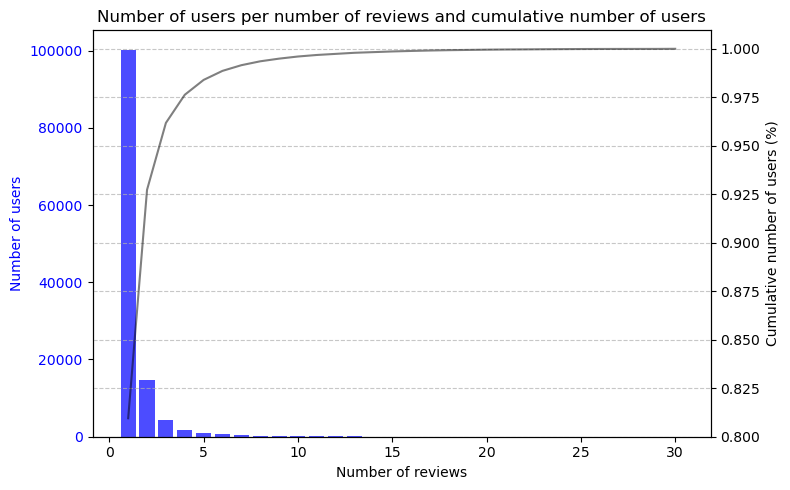

In [53]:
# Plotting cumulative distribution of reviews per user
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot number of users per number of reviews
ax1.bar(reviews_amount_users['Number of reviews'], reviews_amount_users['Number of users'], color='blue', alpha=0.7, label='Number of users')
ax1.set_xlabel('Number of reviews')
ax1.set_ylabel('Number of users', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot cumulative number of users on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(reviews_amount_users['Number of reviews'], reviews_amount_users['Cumulative'], color='black', alpha=0.5, label='Cumulative users')
ax2.set_ylabel('Cumulative number of users (%)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.title('Number of users per number of reviews and cumulative number of users')
fig.tight_layout()
plt.grid(axis = 'both', linestyle='--', alpha=0.7)
plt.show()

### Results: 
Most users (more than 90%) write less then 5 reviews, indicating that the majority of Yelp users are occasional contributors.

## Useful and positive reviews
Now let's explore the useful and stars features. The useful feature indicate how many users thought a review was helpful, and the starts feature indicates if the review is positive or not on a scale from 1 to 5.

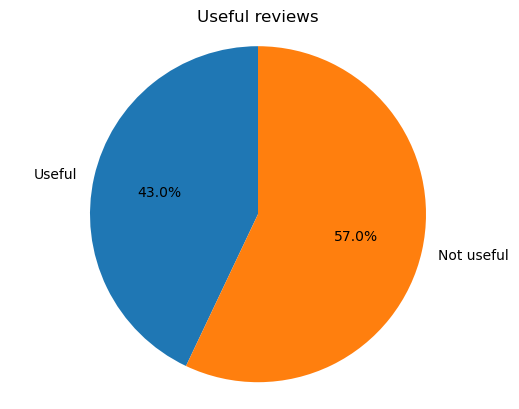

In [54]:
# useful reviews - any review that got at least one useful vote
# Note: its possible to have a review with zero useful votes and still be a helpful review, but for this analysis we will consider only reviews with at least one useful vote.
usefull_reviews = reviews[reviews['useful'] > 0].shape[0]
plt.pie([usefull_reviews, reviews.shape[0] - usefull_reviews], labels=['Useful', 'Not useful'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Useful reviews')
plt.show()

According to the above chart - most reviews are not usefull. thats probably because the old popular reviews hidding new reviews.

Now let's insert a new feature: narrative. if a review got more then 3 start the narrative is possitive.

In [55]:
# add narrative by stars rating. if a review got more than 3 stars the narrative is positive.
# Note: this is a simple heuristic and may not reflect the actual sentiment of the review.
reviews['narrative'] = reviews['stars'].apply(lambda x: 1 if x > 3 else 0)

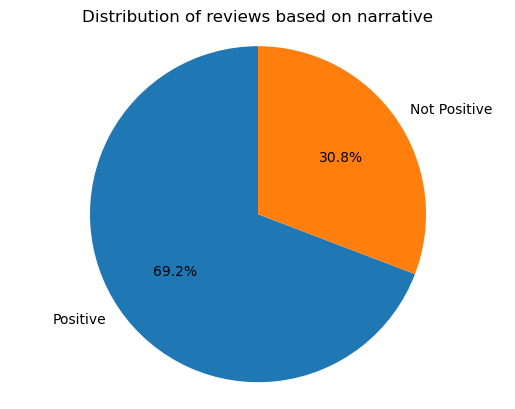

In [56]:
# Plotting distribution of reviews based on narrative
positive_reviews = reviews[reviews['narrative'] > 0].shape[0]
plt.pie([positive_reviews, reviews.shape[0] - positive_reviews], labels=['Positive', 'Not Positive'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of reviews based on narrative')
plt.show()

According to the chart above - most reviews (70%) are positive. This fact suggests a bias towards positive reviews in the dataset, that could effect sentiment analysis and clustering analysis later.

Now, let's see how the two features (useful and narrative) correlate. Are positive reviews more usefull then negetive ones?

In [57]:
# inseerting a binary feature for usefull reviews
reviews['is_useful'] = reviews['useful'].apply(lambda x: 1 if x > 0 else 0)

In [58]:
# counting useful reviews based on narrative
# Create a DataFrame to summarize useful reviews by narrative
data = pd.DataFrame(
    index = ['positive', 'negative'],
    columns = ['useful', 'not_useful'],
    dtype=float,
    data = [
        [reviews[reviews['narrative'] == 1]['is_useful'].sum(), reviews[reviews['narrative'] == 1]['is_useful'].count() - reviews[reviews['narrative'] == 1]['is_useful'].sum()],
        [reviews[reviews['narrative'] == 0]['is_useful'].sum(), reviews[reviews['narrative'] == 0]['is_useful'].count() - reviews[reviews['narrative'] == 0]['is_useful'].sum()]
    ]

)

data

useful  not_useful
positive  48360.0     71791.0
negative  26221.0     27266.0

In [59]:
# converting the counts to percentages

total_positive = data.loc['positive'].sum()
total_negetive = data.loc['negative'].sum()

data.loc['positive', 'useful'] = data.loc['positive', 'useful'] / total_positive
data.loc['positive', 'not_useful'] = data.loc['positive', 'not_useful'] / total_positive

data.loc['negative', 'useful'] = data.loc['negative', 'useful'] / total_negetive
data.loc['negative', 'not_useful'] = data.loc['negative', 'not_useful'] / total_negetive

data

useful  not_useful
positive  0.402494    0.597506
negative  0.490231    0.509769

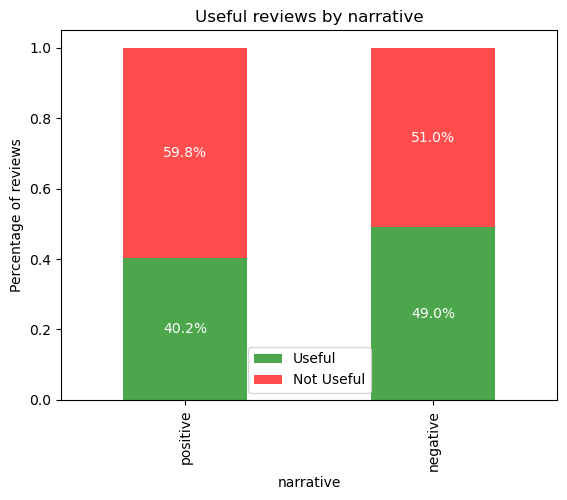

In [60]:
# plotting the useful reviews by narrative
data.plot.bar(stacked=True, color=['green', 'red'], alpha=0.7)
plt.title('Useful reviews by narrative')
plt.xlabel('narrative')
plt.ylabel('Percentage of reviews')
plt.legend(['Useful', 'Not Useful'])
for container in plt.gca().containers:
    plt.bar_label(container, labels=[f"{v:.1%}" for v in container.datavalues], label_type='center', fontsize=10, color='white')
plt.show()


There is a small bias - negative reviews are slightly more useful than positive reviews.

### Top Users
Now let's explore the top 20 users - users with a high number of reviews. This step will help us understand the heavy users of Yelp.

In [61]:
# finding the top 20 users
top_20_users = reviews.groupby('user_id')['review_id'].count().sort_values(ascending=False).head(20)
top_20_users = top_20_users.reset_index()
top_20_users.columns = ['user_id', 'number_of_reviews']

In [62]:
print(top_20_users)

                   user_id  number_of_reviews
0   _BcWyKQL16ndpBdggh2kNA                120
1   Xw7ZjaGfr0WNVt6s_5KZfA                 75
2   0Igx-a1wAstiBDerGxXk2A                 58
3   1HM81n6n4iPIFU5d2Lokhw                 57
4   Um5bfs5DH6eizgjH3xZsvg                 52
5   ouODopBKF3AqfCkuQEnrDg                 51
6   I2XpWCHAom1JRyHXZQrnfg                 47
7   2iS1vg5TYpV_iEiNC8osTg                 46
8   qjfMBIZpQT9DDtw_BWCopQ                 41
9   GcdYgbaF75vj7RO6EZhPOQ                 40
10  bYENop4BuQepBjM1-BI3fA                 40
11  lAW03ccfMEuRZiDqvVgc0w                 39
12  Jt3GylPuH64uA3zTdbMdCg                 39
13  vYMvOTL31e0KbTo9Hd0tjg                 38
14  lYQk0R6sPfo3WeX-l_5BuA                 38
15  47oIw-CN1guUKx2_vUdsgw                 38
16  iPkdNziqnhNukjnmsrSzmg                 37
17  z9uf9-0uX5Jh8-4Y5l2PQg                 36
18  CfX4sTIFFNaRchNswqhVfg                 36
19  RCZ5M9o2-fxgFuurpmEs3w                 35


Distinguishing between top 20 users and rest, so we can analyse the difference in the reviews of these groups.

In [63]:
# filtering the reviews of the top 20 users
# adding a binary feature for top 20 users
reviews['top_20'] = reviews['user_id'].isin(top_20_users['user_id']).astype(int)
top_20_reviews = reviews[reviews['top_20'] == 1]

# how many reviews did the top 20 users write?
print("Top 20 users reviews:")
print("- sum reviews:", top_20_users.number_of_reviews.sum())
print("- average reviews per user:", top_20_users.number_of_reviews.mean())
print()
print("All reviews:")
print("- sum reviews:", reviews['review_id'].count())
print("- average reviews per user:", f"{reviews.groupby('user_id')['review_id'].count().mean():.2f}")
print()
print("- percentage of top 20 users reviews:", top_20_users.number_of_reviews.sum() / reviews['review_id'].count() * 100, "%")


Top 20 users reviews:
- sum reviews: 963
- average reviews per user: 48.15

All reviews:
- sum reviews: 173638
- average reviews per user: 1.40

- percentage of top 20 users reviews: 0.5546021032262524 %


Top users are responsible for a small part of the reviews, but they write more reviews per user.

In [64]:
# Separation of non top 20 users reviews for comparison
non_top_20_reviews = reviews[reviews.top_20 == 0]

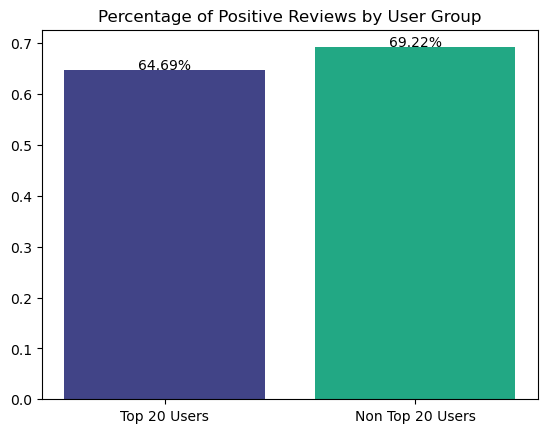

In [65]:
# Comparing the percentage of positive reviews (narrative > 0) between top 20 users and non-top 20 users
positive_reviews_non_top_20 = non_top_20_reviews[non_top_20_reviews['narrative'] > 0].shape[0] / non_top_20_reviews.shape[0]
positive_reviews_top_20 = top_20_reviews[top_20_reviews['narrative'] > 0].shape[0] / top_20_reviews.shape[0]

plt.bar(
    ['Top 20 Users', 'Non Top 20 Users'],
    [positive_reviews_top_20, positive_reviews_non_top_20],
    color=['#414487', '#22a884']
)
# add data labels
for i, v in enumerate([positive_reviews_top_20, positive_reviews_non_top_20]):
    plt.text(i, v - 0.005, f"{v:.2%}", ha='center', va='bottom', fontsize=10)
plt.title('Percentage of Positive Reviews by User Group')
plt.show()

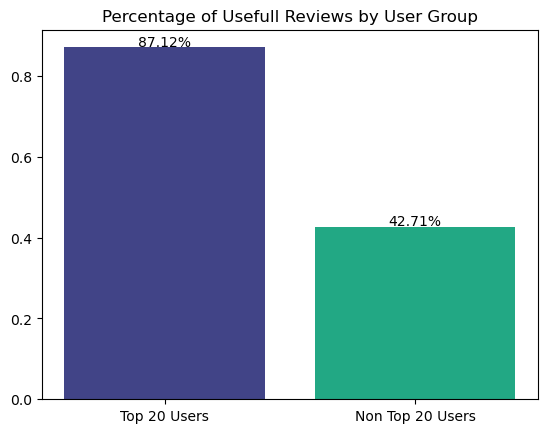

In [67]:
# Comparing the percentage of useful reviews (narrative > 0) between top 20 users and non-top 20 users
usefull_reviews_non_top_20 = non_top_20_reviews[non_top_20_reviews['is_useful'] > 0].shape[0] / non_top_20_reviews.shape[0]
usefull_reviews_top_20 = top_20_reviews[top_20_reviews['is_useful'] > 0].shape[0] / top_20_reviews.shape[0]

plt.bar(
    ['Top 20 Users', 'Non Top 20 Users'],
    [usefull_reviews_top_20, usefull_reviews_non_top_20],
      color=['#414487', '#22a884'])
# add data labels
for i, v in enumerate([usefull_reviews_top_20, usefull_reviews_non_top_20]):
    plt.text(i, v - 0.005, f"{v:.2%}", ha='center', va='bottom', fontsize=10)
plt.title('Percentage of Usefull Reviews by User Group')
plt.show()

Top users write marginally less positive reviews, but have disproportionately higher percentage of useful reviews.

let's see if there's a connection between the usefulness and the narrative in top users reviews.

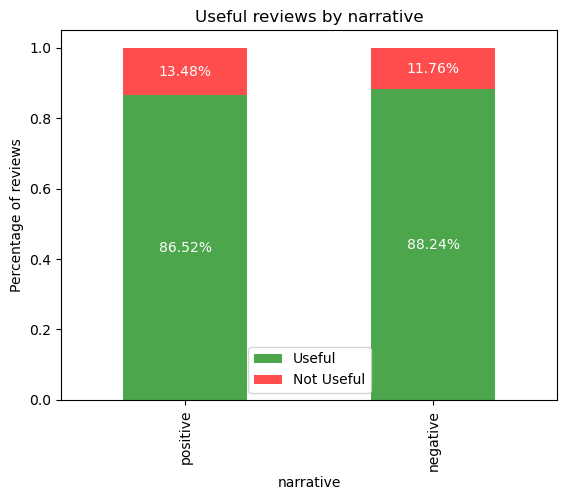

In [68]:
# creating a DataFrame to summarize useful reviews by narrative
data = pd.DataFrame(
    index = ['positive', 'negative'],
    columns = ['useful', 'not_useful'],
    data = [
        [top_20_reviews[top_20_reviews['narrative'] == 1]['is_useful'].sum(), top_20_reviews[top_20_reviews['narrative'] == 1]['is_useful'].count() - top_20_reviews[top_20_reviews['narrative'] == 1]['is_useful'].sum()],
        [top_20_reviews[top_20_reviews['narrative'] == 0]['is_useful'].sum(), top_20_reviews[top_20_reviews['narrative'] == 0]['is_useful'].count() - top_20_reviews[top_20_reviews['narrative'] == 0]['is_useful'].sum()]
    ]

)
total_positive = data.loc['positive'].sum()
total_negetive = data.loc['negative'].sum()

# setting dtype to float for percentage calculations
data = data.astype(float)

# converting the counts to percentages
data.loc['positive', 'useful'] = data.loc['positive', 'useful'] / total_positive
data.loc['positive', 'not_useful'] = data.loc['positive', 'not_useful'] / total_positive

data.loc['negative', 'useful'] = data.loc['negative', 'useful'] / total_negetive
data.loc['negative', 'not_useful'] = data.loc['negative', 'not_useful'] / total_negetive

# plotting the useful reviews by narrative
data.plot.bar(stacked=True, color=['green', 'red'], alpha=0.7)
plt.title('Useful reviews by narrative')
plt.xlabel('narrative')
plt.ylabel('Percentage of reviews')
plt.legend(['Useful', 'Not Useful'])
for container in plt.gca().containers:
    plt.bar_label(container, labels=[f"{v:.2%}" for v in container.datavalues], label_type='center', fontsize=10, color='white')
plt.show()

From the chart above it seems there's a very weak connection between narrative and usefulness, we can also look at a correlation heatmap below.

Coorelation between usefulness and narrative: 0.04


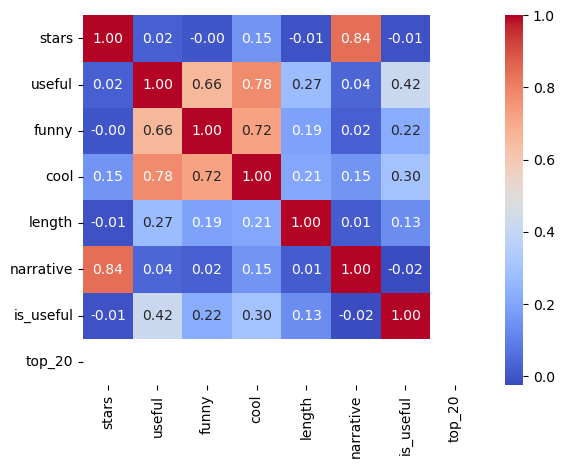

In [69]:
# view the correlation between the features in the top 20 users reviews
# Note: only numerical features are considered for correlation
# it is also expected that the correlation between narrative and stars is high, as the narrative is based on the stars rating
data = reviews[reviews.top_20 == 1].copy()
data = data.select_dtypes(include=['int64', 'float64'])  # Keep only numerical columns
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')

print("Coorelation between usefulness and narrative:", f"{data['narrative'].corr(data['useful']):.2f}")

The weak correlation shows that users vote "useful" regardless of the narrative being positive or negetive.

In [70]:
# Adding a binary feature to indicate if the user is in the top 20 users
reviews['top_20'] = reviews['user_id'].apply(lambda x: 1 if x in top_20_users['user_id'].values else 0)

## Looking at the text
### Text processing
Looking at the textual content of the reviews to find hidden patterns and frequently used words.

Word clouds visualise common words frequency, the size of each word represents its frequency.

In [71]:
def create_wordcloud(text, title, max_words=20):
    # This function generates a word cloud from the given text and displays it with a title.
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def compare_words_frequency(text1, text2, title1, title2, max_words=50, sort_by_index=0):
    # This function compares the frequency of words in two texts and plots the top common words.
    words1 = word_tokenize(text1.lower())
    words2 = word_tokenize(text2.lower())

    amount_words1 = len(text1.split())
    amount_words2 = len(text2.split())
    
    fdist1 = FreqDist(words1)
    fdist2 = FreqDist(words2)
    
    common_words = set(fdist1.keys()).intersection(set(fdist2.keys()))
    common_words = set(fdist1.keys()).union(set(fdist2.keys()))
    
    freq_df = pd.DataFrame({
        'Word': list(common_words),
        'Frequency in ' + title1: [fdist1[word]/amount_words1 for word in common_words],
        'Frequency in ' + title2: [fdist2[word]/amount_words2 for word in common_words]
    })
    
    if sort_by_index == 0:
        freq_df = freq_df.sort_values(by='Frequency in ' + title1, ascending=False).head(max_words)
    else:
        freq_df = freq_df.sort_values(by='Frequency in ' + title2, ascending=False).head(max_words)
    
    freq_df.plot(x='Word', kind='bar', stacked=False, color=['blue', 'orange'], figsize=(10*max(1,max_words/20), 5))
    plt.title('Top 20 Common Words Frequency Comparison')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

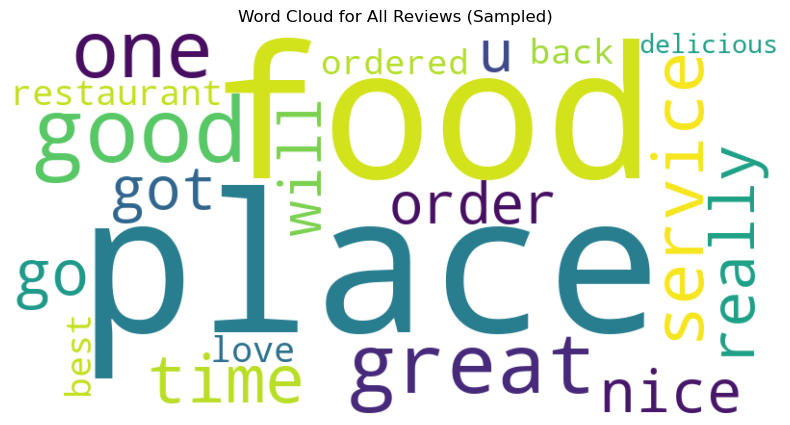

In [72]:
# Sample size for faster processing
sample_size = 5000

# Word cloud for all reviews (randomly sampled)
all_reviews_text = ' '.join(reviews['text'].sample(n=sample_size, random_state=42).astype(str))
create_wordcloud(all_reviews_text, 'Word Cloud for All Reviews (Sampled)')


The word cloud above displays the 25 most frequent words in the sampled reviews.
Larger font size indicates higher frequency.
But we also get stop words (u, will) and its hard to compare different groups like top users vs regular users using word cloud.

So we need clean and preprocess the text and use tf-idf to learn about the difference in freq. amoug these groups.

### Text preprocessing and cleaning
In this section, we remove stop words, converting to lowercase and apply stemming to the text.

In [73]:
# Preprocessing the text
stop_words = stopwords.words('english') # stopwords are words that do not add much meaning to a sentence
stemmer = SnowballStemmer('english') # stemming is the process of reducing a word to its root form
lemmatizer = WordNetLemmatizer() # lemmatization is the process of reducing a word to its root form too

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+" # regular expression to remove the unwanted characters (like emojis, links, etc.)

In [74]:
# removing stopwords
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

print('Preprocessing text:')
# lowercasing the text
reviews.text = reviews.text.str.lower()
# removing unwanted characters and stopwords
reviews.text = reviews.text.apply(lambda x: preprocess(x, stem=True))  # stemming is applied to reduce words to their root form (ordered -> order)
# removing non alphabetic characters and removing digits
reviews.text = reviews.text.str.replace('[^a-zA-Z]', ' ')
reviews.text = reviews.text.str.replace(r'\d+', '', regex=True)
# remove too many spaces
reviews.text = reviews.text.str.replace(r'\s+', ' ', regex=True)

reviews.head()

Preprocessing text:


review_id                 user_id             business_id  \
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   
5  JrIxlS1TzJ-iCu79ul40cQ  eUta8W_HdHMXPzLBBZhL1A  04UD14gamNjLY0IDYVhHJg   

   stars  useful  funny  cool  \
1      5       1      0     1   
2      3       0      0     0   
3      5       1      0     1   
4      4       1      0     1   
5      1       1      2     1   

                                                text  length  year  month  \
1  taken lot spin class year noth compar class bo...     151  2012      1   
2  famili diner buffet eclect assort larg chicken...      55  2014      2   
3  wow yummi differ delici favorit lamb curri kor...      40  2015      1   
4  cute interior owner gave us tour upcom patio r...      94  2017      1   
5  long term frequent custom establish went order...      65  2015      9   

   day  narrative  is_useful  top_20  
1    3          1          1       0  
2    5          0          0       0  
3    4          1          1       0  
4   14          1          1       0  
5   23          0          1       0

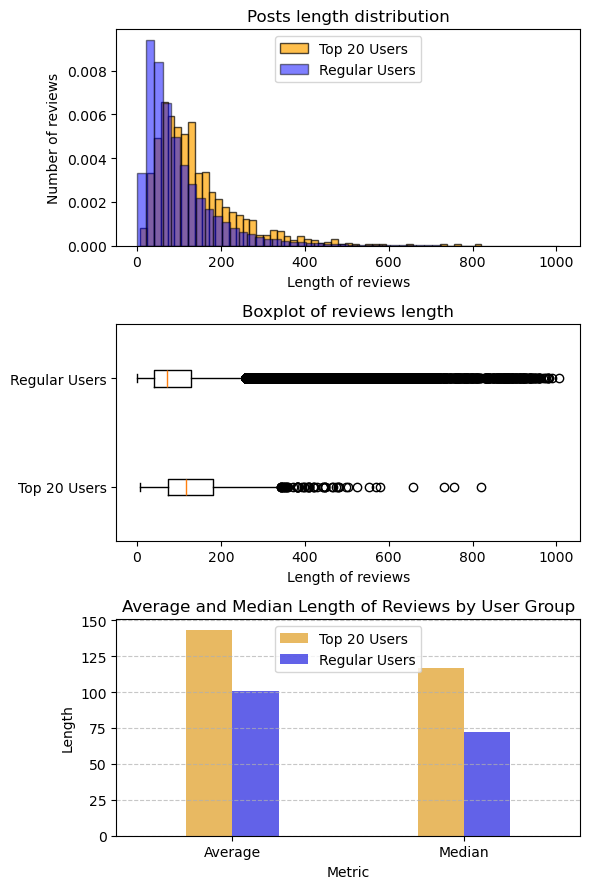

In [109]:
# plot reviews length distribution with histogram and boxplot
fig, ax = plt.subplots(3  , 1, figsize=(6, 9))

# Histogram
#ax[0].hist(reviews.length, bins=50, color='skyblue' , edgecolor='black', linewidth=1.2, alpha=0.3, density=True)
ax[0].hist(reviews[reviews.top_20 == 1].length, bins=50, color='orange' , edgecolor='black',  alpha=0.7, density=True)
ax[0].hist(reviews[reviews.top_20 == 0].length, bins=50, color='blue' , edgecolor='black',  alpha=0.5, density=True)
ax[0].set_xlabel('Length of reviews')
ax[0].set_ylabel('Number of reviews')
ax[0].set_title('Posts length distribution')
# Add legend to the histogram
ax[0].legend(['Top 20 Users', 'Regular Users'], loc='upper center')

# Boxplot
ax[1].boxplot([reviews[reviews.top_20 == 1].length, reviews[reviews.top_20 == 0].length],
    tick_labels=['Top 20 Users', 'Regular Users']
              , vert=False)
ax[1].set_xlabel('Length of reviews')
ax[1].set_title('Boxplot of reviews length')

# avrage and median bar comparison
avg_top_20 = reviews[reviews.top_20 == 1].length.mean()
avg_non_top_20 = reviews[reviews.top_20 == 0].length.mean()
median_top_20 = reviews[reviews.top_20 == 1].length.median()
median_non_top_20 = reviews[reviews.top_20 == 0].length.median()
data_for_bar_plot = pd.DataFrame({
    'User Group': ['Top 20 Users', 'Top 20 Users', 'Regular Users', 'Regular Users'],
    'Metric': ['Average', 'Median', 'Average', 'Median'],
    'Length': [avg_top_20, median_top_20, avg_non_top_20, median_non_top_20]
})

sns.barplot(data=data_for_bar_plot, x='Metric', y='Length', hue='User Group',
             palette=['orange', 'blue'], alpha=0.7, ax=ax[2], width=0.4)

ax[2].legend(loc='upper center')
ax[2].set_xlabel('Metric')
ax[2].set_title('Average and Median Length of Reviews by User Group')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

These plots show us that top 20 users write longer reviews.

Now lets see the connection between length and stars rating.

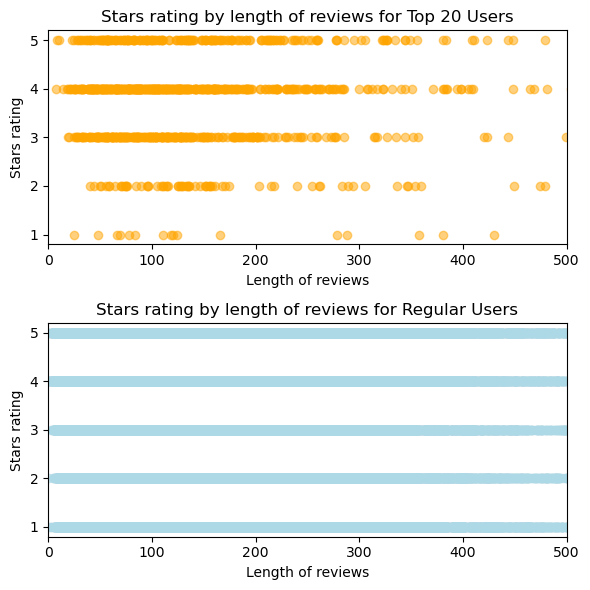

Coorelation between stars and length (Top Users): 0.01
Coorelation between stars and length (Regular Users): -0.18


In [110]:
# plotting the stars rating by length of reviews for top 20 users and regular users
fig, ax = plt.subplots(2  , 1, figsize=(6, 6))

ax[0].scatter(reviews[reviews.top_20 == 1].length, reviews[reviews.top_20 == 1].stars, color='orange', alpha=0.5, label='Top 20 Users')
ax[0].set_xlim(0, 500)

ax[1].scatter(reviews[reviews.top_20 == 0].length, reviews[reviews.top_20 == 0].stars, color='lightblue', alpha=0.5, label='Regular Users')
ax[1].set_xlim(0, 500)
ax[0].set_xlabel('Length of reviews')
ax[0].set_ylabel('Stars rating')
ax[1].set_xlabel('Length of reviews')
ax[1].set_ylabel('Stars rating')
ax[0].set_title('Stars rating by length of reviews for Top 20 Users')
ax[1].set_title('Stars rating by length of reviews for Regular Users')
plt.tight_layout()
plt.show()

print("Coorelation between stars and length (Top Users):", f"{reviews[reviews.top_20 == 1]['stars'].corr(reviews[reviews.top_20 == 1]['length']):.2f}")
print("Coorelation between stars and length (Regular Users):", f"{reviews[reviews.top_20 == 0]['stars'].corr(reviews[reviews.top_20 == 0]['length']):.2f}")

Very weak correlation between stars and length on both categories, top users show a positive but close to 0 collation, regular users show a weak negative correlation. Meaning that there's almost no correlation between stars and length for top users but for regular users as the star rating is low the review length is high – so when they have bad experience they write a longer review. Let's build another graph to see this connection.

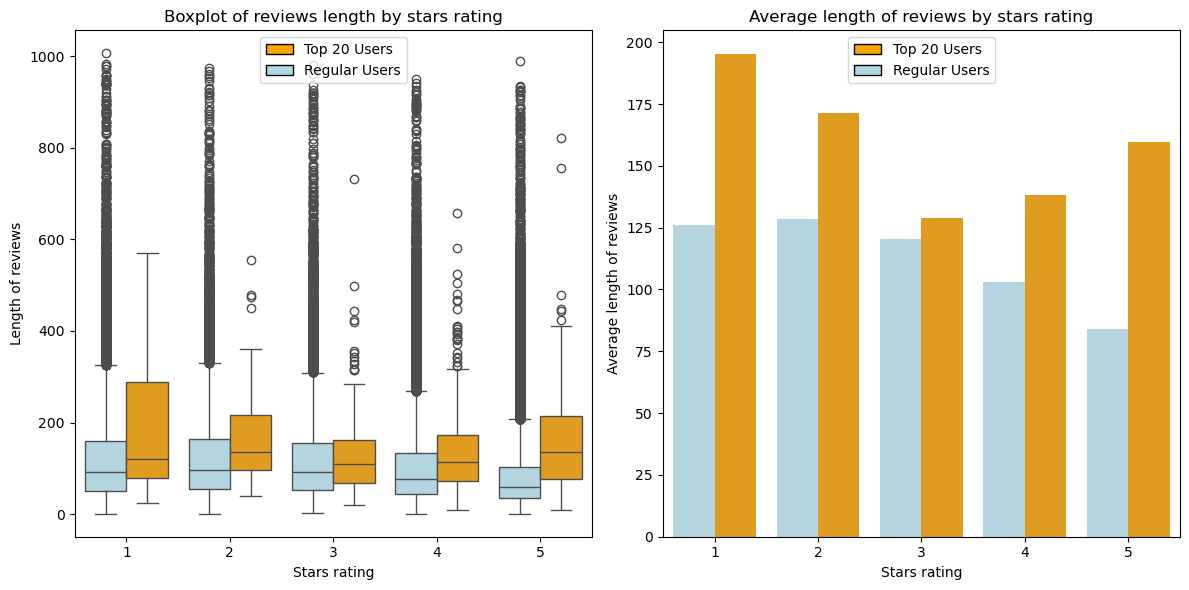

In [111]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(1  , 2, figsize=(12, 6))

sns.boxplot(x='stars', y='length', data=reviews, hue='top_20', palette=['orange', 'lightblue'][::-1], ax=ax[0])
ax[0].set_xlabel('Stars rating')
ax[0].set_ylabel('Length of reviews')
ax[0].set_title('Boxplot of reviews length by stars rating')

reviews_len_stars = reviews.groupby(['stars', 'top_20'])['length'].agg(['mean']).reset_index()
sns.barplot(data=reviews_len_stars, x='stars', y='mean', hue='top_20', palette=['orange', 'lightblue'][::-1], ax=ax[1])
ax[1].set_xlabel('Stars rating')
ax[1].set_ylabel('Average length of reviews')
ax[1].set_title('Average length of reviews by stars rating')

# Set legend with color patches for clarity
legend_labels = ['Top 20 Users', 'Regular Users']
legend_colors = ['orange', 'lightblue']
handles = [Patch(facecolor=color, edgecolor='black', label=label) for color, label in zip(legend_colors, legend_labels)]
ax[1].legend(handles=handles, loc='upper center')
ax[0].legend(handles=handles, loc='upper center')


plt.tight_layout()
plt.show()

Insights:

- Top 20 users has less outliers and write longer reviews.
- Its now more clear - the lower the stars rating (negetive experience), the longer the review (users have a lot more to say).

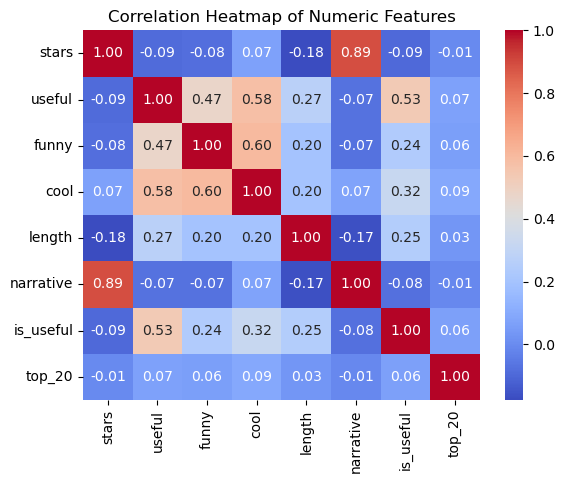

In [112]:
# view the correlation between the features in all the reviews
# Note: It is expected that the correlation between narrative and stars is high, as the narrative is based on the stars rating
data = reviews.copy()
# Select only numeric columns
numeric_cols = data.select_dtypes(include=['int', 'float']).columns
data_numeric = data[numeric_cols]

sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

Notable observations from the correlation heatmap:
* a positive correlation between review length and useful, users fine longer reviews useful.
* a negative correlation between length and stars/narrative, as shown above.
* a positive correlation between the useful, funny, cool features.

In [113]:
# fix the data types of the reviews DataFrame
reviews = reviews.convert_dtypes()

### Tokenization using TF-IDF

This action will convert the text to a vector with tf-idf weights (the frequency of the word in the text), for a better analysis.

In [114]:
# Sample size for faster processing
sample_size = 200000
sample_reviews = reviews.sample(n=sample_size, random_state=42).astype(str)

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer

MAX_NB_WORDS = 500  # Maximum number of words to consider
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=MAX_NB_WORDS, max_df=0.8, min_df=5)
X = vectorizer.fit_transform(sample_reviews['text'])

X

<200000x500 sparse matrix of type '<class 'numpy.float64'>'
	with 5340564 stored elements in Compressed Sparse Row format>

We created a matrix that represents the text as a numeric vector. Each row is one review and every number is the tf-idf weight of one word in the review.

Using tf-idf we can explore how these two group differ in word usage.

In [116]:
# finding the top 20 users based on the number of reviews
top_20_users = sample_reviews['user_id'].value_counts().head(20).index
top_20_mask = sample_reviews['user_id'].isin(top_20_users).values

# claulate the mean weight of each word in the top 20 users reviews
top_20_weights = X[top_20_mask].mean(axis=0)
other_weights = X[~top_20_mask].mean(axis=0)

diff = top_20_weights - other_weights
print("Shape of the difference vector:", diff.shape)
diff # this is the difference between the top 20 users and the rest of the users in terms of word frequency

Shape of the difference vector: (1, 500)


matrix([[ 3.03541603e-03, -1.99317505e-03,  3.91043283e-03,
          3.72872233e-03,  1.64822244e-03, -8.13817021e-04,
          4.93559395e-04,  7.82090125e-03,  5.85117821e-03,
         -2.53184223e-03, -1.35182315e-02, -1.14389269e-03,
          9.57206283e-04, -2.04395902e-03,  1.07211631e-03,
         -6.00249850e-04,  8.49317608e-03,  4.73587313e-03,
         -1.26457843e-03, -4.15817604e-03,  1.11662790e-03,
         -7.21911473e-03, -3.61335684e-03, -2.15631342e-03,
          1.29218195e-03, -5.42662796e-04, -1.36710662e-05,
         -9.04904225e-03, -2.53281065e-03,  3.51925625e-03,
         -1.89642918e-03,  9.25120250e-03, -6.17100318e-04,
          2.05087350e-03,  9.87910760e-04,  2.51730961e-03,
         -2.13270621e-03, -7.18196919e-04, -1.52538690e-03,
         -1.07776206e-02,  2.61912648e-03,  5.80880052e-03,
          9.48024241e-03,  3.10406731e-04,  1.09845285e-03,
          2.11971453e-03,  2.34017889e-03, -1.57115542e-03,
          2.32509042e-03, -2.61731883e-0

We get a new metrix with one row, reprenting the difference in the avrage usage for each word. 

Since the calculation was top_20_weights - other_weights the top values are the words most common among the top 20 user, and the bottom values are the words most common among the regular users.

In [86]:
diff = diff.A1  # Convert sparse matrix to dense array
diff = pd.Series(diff, index=vectorizer.get_feature_names_out()) # Get the actual words and convert to a Series
diff = diff.sort_values(ascending=False)  # Sort the words by frequency difference

NameError: name 'diff' is not defined

In [118]:
print("Top 10 words that appers more with top 20 users:")
print(diff.head(10))
print()
print("Top 10 words that appers more with regular users:")
print(diff.tail(10))

Top 10 words that appers more with top 20 users:
good      0.018546
store     0.017884
pretti    0.017578
locat     0.013544
shop      0.013165
like      0.012149
lot       0.011795
old       0.011480
select    0.011376
well      0.010527
dtype: float64

Top 10 words that appers more with regular users:
excel       -0.007621
us          -0.008194
awesom      -0.009049
staff       -0.010647
best        -0.010778
servic      -0.011815
food        -0.012869
recommend   -0.013481
amaz        -0.013518
great       -0.021914
dtype: float64


Lets plot the words and their values for better clearity.

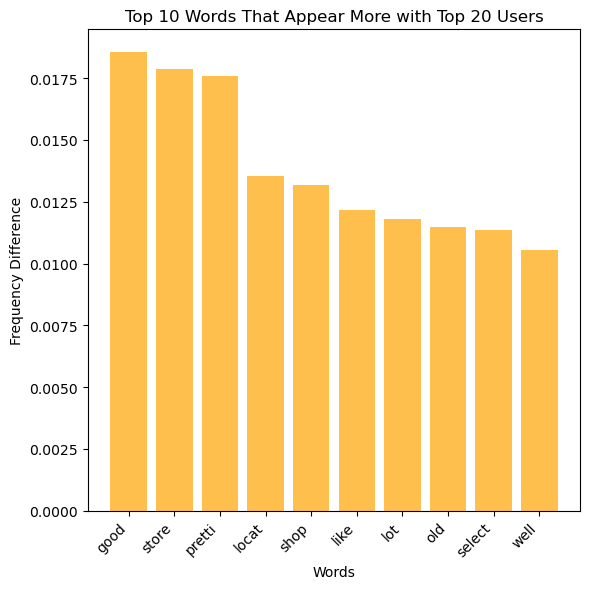

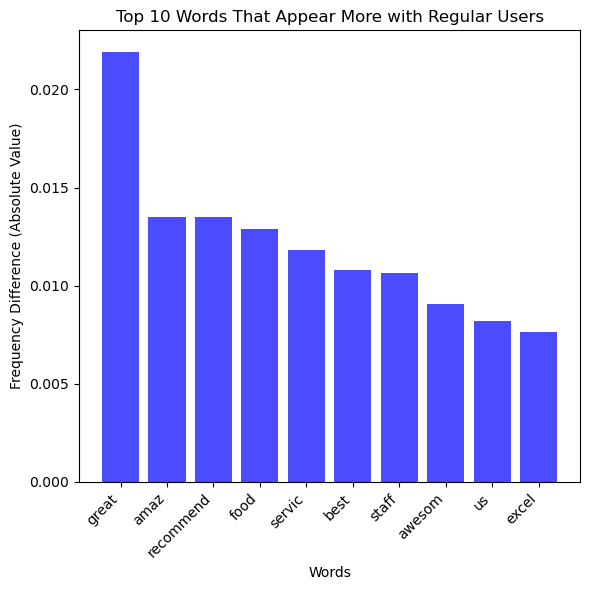

In [119]:
# Plotting the top 10 words that appear more with top 20 users and the top 10 words that appear more with regular users
plt.figure(figsize=(6, 6))
plt.bar(diff.index[:10], diff.values[:10], color='orange', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Words That Appear More with Top 20 Users')
plt.xlabel('Words')
plt.ylabel('Frequency Difference')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.bar(diff.index[-10:][::-1], abs(diff.values[-10:][::-1]), color='blue', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Words That Appear More with Regular Users')
plt.xlabel('Words')
plt.ylabel('Frequency Difference (Absolute Value)')
plt.tight_layout()
plt.show()

Insights:
- Regular users using emotional words: amazing, awesome, best.
- Top 20 users describe the loacation (store, shop, locate) and less amotional descriptions (good, like).
- Its lesss common for a top user to use the word 'recommend' in the review.

## Dimensionality reduction
### Using dimensionality reduction to see if the groups are visually separate. 
If the groups are visually seprate, it confirms that the entire text style of the top 20 users is different. Otherwise, the difference is among the spesific word in the above charts.

- The review text in multi-dimensional (each word is one dimension), but we can only see up to 3D. 
- To convert the text into a 2d vector we can use several methods:
    1. PCA - Takes only the n_components (in this case = 2) where the varience is the highest. (Linear)
    2. TSNE - Using a much more time consuming non-linear stochastic algorythm. Can detect hidden local similarity that PCA missed, but the results is unstable because of its stochastic nature.
    3. UMAP - Can detect local similarities like TSNE better than PCA and find global similarities between group better then TSNE, using less runtime and with much tabler results.  

In [120]:
# Dimensionality reduction using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_reduced_plt = pca.fit_transform(X)
X_reduced_plt = pd.DataFrame(X_reduced_plt, columns=['Component 1', 'Component 2'])
X_reduced_plt.loc[top_20_mask, 'User Type'] = 'Top 20 Users'
X_reduced_plt.loc[~top_20_mask, 'User Type'] = 'Regular Users'
X_reduced_plt.head()

Component 1  Component 2      User Type
0     0.075443    -0.019926  Regular Users
1     0.040733    -0.159893  Regular Users
2    -0.009520    -0.058918  Regular Users
3     0.028684    -0.184657  Regular Users
4     0.125910     0.071624  Regular Users

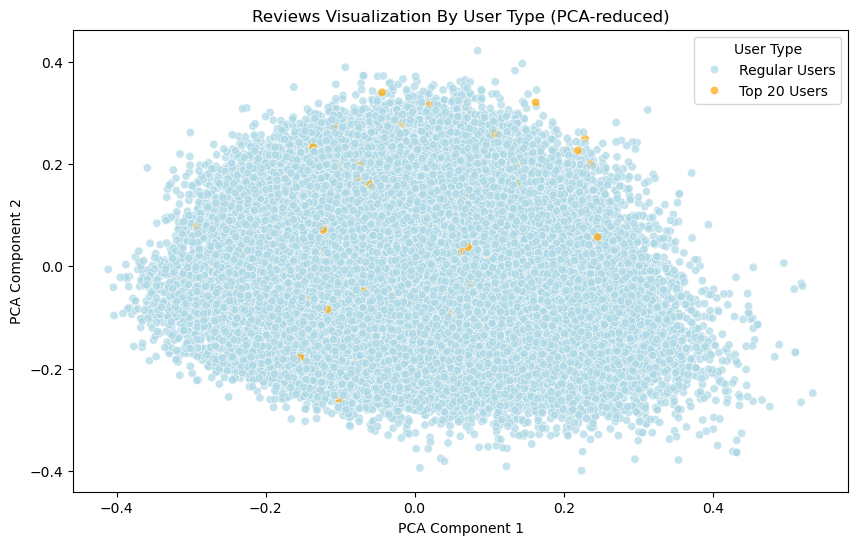

In [121]:
# Plotting the PCA-reduced data with user type
plt.figure(figsize=(10, 6))
sns.scatterplot(
	data=X_reduced_plt,
	x='Component 1',
	y='Component 2',
	hue='User Type',
	palette=['orange', 'lightblue'][::-1],
	alpha=0.7
)
plt.title('Reviews Visualization By User Type (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='User Type')
plt.show()

In the chart above we can see the 2 most meaningfull components of each review vizualize. We're looking for a clear and unique cluster for each group, but unfortunatly it's not the case here. The top 20 users reviews are scattered along side the rest. 

Let's try again using TSNE. This method is much more time consuming than PCA because of its non-linear algorythem, but it can detect hidden similarities better. (I comment these blocks out to save time and pasted the results below)

In [122]:
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
# X_tnse = tsne.fit_transform(X.toarray())
# X_tnse = pd.DataFrame(X_tnse, columns=['Component 1', 'Component 2'])
# X_tnse.loc[top_20_mask, 'User Type'] = 'Top 20 Users'
# X_tnse.loc[~top_20_mask, 'User Type'] = 'Regular Users'

In [123]:
# # Plotting the TSNE-reduced data with user type
# plt.figure(figsize=(10, 6))
# sns.scatterplot(
# 	data=X_tnse,
# 	x='Component 1',
# 	y='Component 2',
# 	hue='User Type',
# 	palette=['orange', 'lightblue'][::-1],
# 	alpha=0.7
# )
# plt.title('Reviews Visualization By User Type (TSNE-reduced)')
# plt.xlabel('TSNE Component 1')
# plt.ylabel('TSNE Component 2')
# plt.legend(title='User Type')
# plt.show()

TSNE Results:

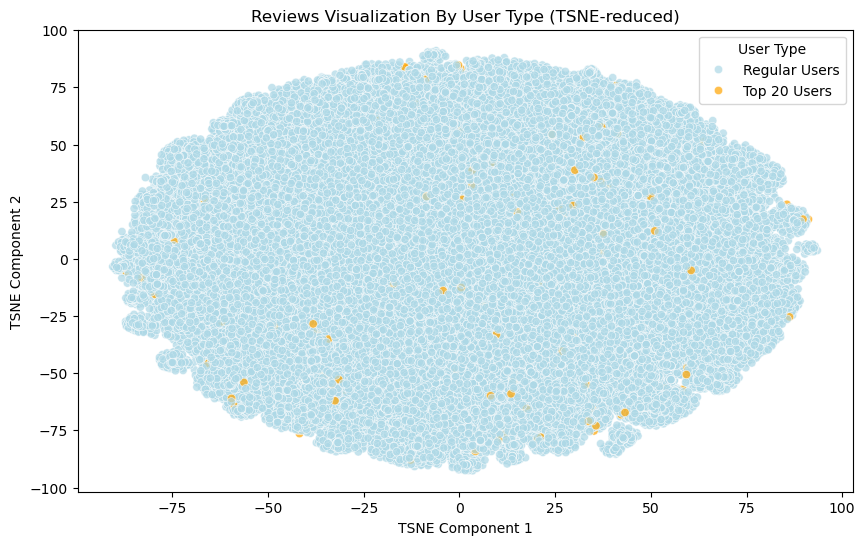

TSNE also didn't provided clear groups. This points to a much less distinctive groups and similar text styles. The differebt word usage we saw earlier is distinctive but not enough to impact the text style visualized.

Let's try with UMAP algorythm, it might detect better global distances among groups.

In [124]:
# UMAP for dimensionality reduction
array_X = X.toarray() if hasattr(X, "toarray") else X
array_X = array_X.astype(np.float32) # Convert to float32 for UMAP compatibility

print(np.isnan(array_X).sum())
print("Shape of the array:", array_X.shape)
print(array_X)

0
Shape of the array: (200000, 500)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.16090716 0.         0.         ... 0.         0.         0.        ]
 [0.         0.03219721 0.12509812 ... 0.         0.         0.03749151]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [125]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(array_X)
X_umap.shape

/opt/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(200000, 2)

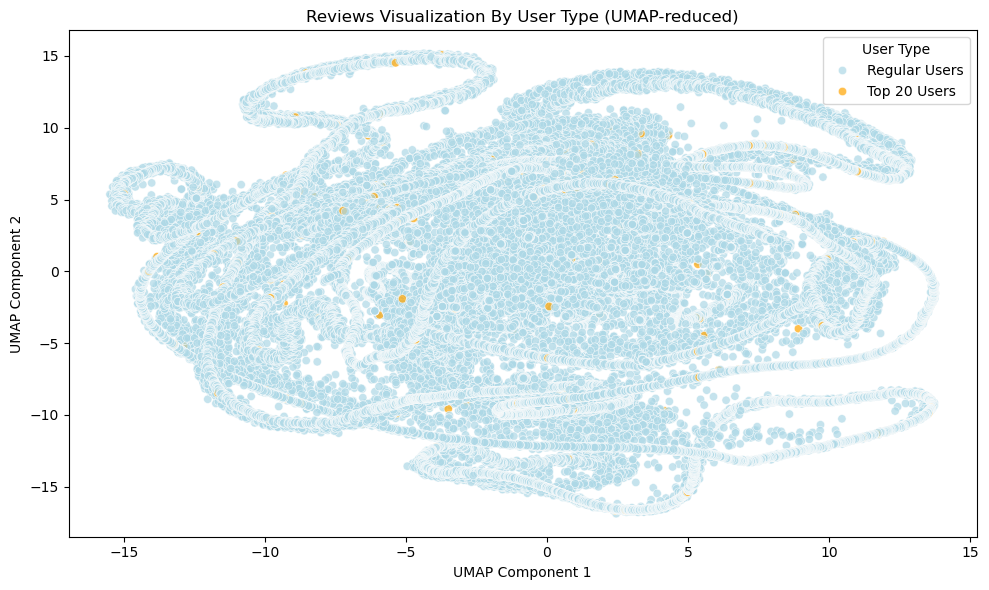

In [126]:
# Build DataFrame
X_umap_df = pd.DataFrame(
    X_umap,
    columns=["Component 1", "Component 2"]
)
# assign user type labels
X_umap_df["User Type"] = ["Top 20 Users" if flag else "Regular Users" 
                       for flag in top_20_mask]

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=X_umap_df,
    x="Component 1",
    y="Component 2",
    hue="User Type",
    palette=["orange","lightblue"][::-1],
    alpha=0.7
)
plt.title("Reviews Visualization By User Type (UMAP-reduced)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title="User Type")
plt.tight_layout()
plt.show()


This time the results are more "interesting", but still without any distinct groups and the top 20 users are spread across the rest of the reviews.

Insights:
- There are no distict writing style to the top users, even though they often use different vocabulary than the regular users.

What's next?
- We can try to detect other groups, perhaps more complex than the user type based we defined earlier, using clustering algorythms.
- We might be able to detect "noise" using DBSCAN Clustering and explore its content - is it spam? different style?

## Clustering Analysis
### Let's explore groups in the dataset using K-Means, DBSCAN and agglomerative Hierarchical Clustering.

In [127]:
# Continuing with the UMAP reduced data
X_reduced = X_umap

In [128]:
# setting a new column for the cluster labels
sample_reviews['cluster'] = pd.NA

In [129]:
# Function to perform clustering analysis and detecting the differences between clusters
def cluster_analysis_grouped(df, cluster_col='cluster'):
    """
    Analyze clusters and plot grouped bar charts by comparison type.
    """
    # Prepare the metrics
    cluster_counts = df[cluster_col].value_counts(normalize=True).sort_index().reset_index()
    cluster_counts.columns = [cluster_col, '% Review Count']

    # % of reviews in each cluster written by top 20 users
    top_20_reviews = df[df['top_20'] == 1].groupby(cluster_col).size()
    total_reviews_per_cluster = df.groupby(cluster_col).size()
    top_20_percentage = (top_20_reviews / total_reviews_per_cluster * 100).fillna(0).reset_index()
    top_20_percentage.columns = [cluster_col, 'Reviews by Top 20 Users %']

    avg_stars = df.groupby(cluster_col)['stars'].mean().reset_index()
    avg_stars.columns = [cluster_col, 'Avg Stars']

    df['review_length'] = df['text'].apply(lambda x: len(str(x).split()))
    avg_length = df.groupby(cluster_col)['review_length'].mean().reset_index()
    avg_length.columns = [cluster_col, 'Avg Review Length']

    avg_narrative = df.groupby(cluster_col)['narrative'].mean().reset_index()
    avg_narrative.columns = [cluster_col, 'Avg narrative']

    # Merge all metrics into one DataFrame
    combined = cluster_counts \
        .merge(top_20_percentage, on=cluster_col, how='outer') \
        .merge(avg_stars, on=cluster_col, how='outer') \
        .merge(avg_length, on=cluster_col, how='outer') \
        .merge(avg_narrative, on=cluster_col, how='outer') \
        .sort_values(by=cluster_col)

    # Melt for plotting
    melted = pd.melt(combined, id_vars=cluster_col,
                     value_vars=['% Review Count', 'Reviews by Top 20 Users %', 'Avg Stars', 'Avg Review Length', 'Avg narrative'],
                     var_name='Metric', value_name='Value')

    # Plotting
    g = sns.catplot(
        data=melted, kind='bar',
        x=cluster_col, y='Value', col='Metric',
        col_wrap=2, sharex=False, sharey=False,
        palette='viridis', height=4, aspect=1.3
    )

    g.set_titles('{col_name}')
    g.set_axis_labels('Cluster', '')
    for ax in g.axes.flat:
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        # Annotate bars with values for better visibility
        for bar in ax.patches:
            height = bar.get_height()
            if not pd.isna(height):
                ax.annotate(f'{height:.2f}', (bar.get_x() + bar.get_width() / 2, height),
                            ha='center', va='bottom', fontsize=8, color='black', rotation=0)

    plt.tight_layout()
    plt.show()

    # Print summary tables
    print("Summary by Cluster:")
    print(combined)


### K-Means
K-Means is a simple method to divide data into groups, but we need to provide it the number of group we think fits the data.

There are two methods to determine the number of groups (clusters) before we start:
- Elbow method - Detects where adding more clusters stop improving the model by calculating Within-Cluster Sum of Squares (WCSS) against the number of clusters. We look for a clear "elbow" shape point in the graph.
- Silhouette score - Measure the quality of the clusters by evaluating how well each points fits the assinged cluser and seperate from other clusters. The score is between -1 (worst clusters) to 1 (good clusers).

Let's try to use the Elbow method to determine a range of number of clusters (k) and then fine-tuning it using Silhouette score (if nessesary).

Note: Due to the shape of graph (blob, no coherent groups) I don't expect to get any meaningfull results for K-Means.

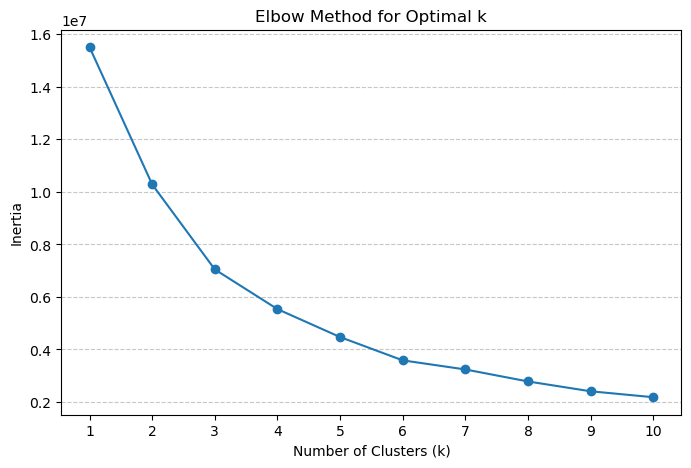

In [130]:
# Elbo method
def calculate_elbow(X, max_k):
    #Calculate the inertia for KMeans clustering for a range of k values.
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    return inertia

# Plotting the elbow method
def plot_elbow(inertia):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(inertia) + 1), inertia, marker='o', linestyle='-')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(range(1, len(inertia) + 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Calculate inertia for KMeans clustering
inertia = calculate_elbow(X_reduced, max_k=10)
# Plot the elbow method
plot_elbow(inertia)

Elbow method didn't provided a clear result since theres no clear Elbow point. Now lets test the Silhouette score for 1 < K < 5.

Number of clusters: 2, Silhouette Score: 0.3038
Number of clusters: 3, Silhouette Score: 0.3257
Number of clusters: 4, Silhouette Score: 0.3098


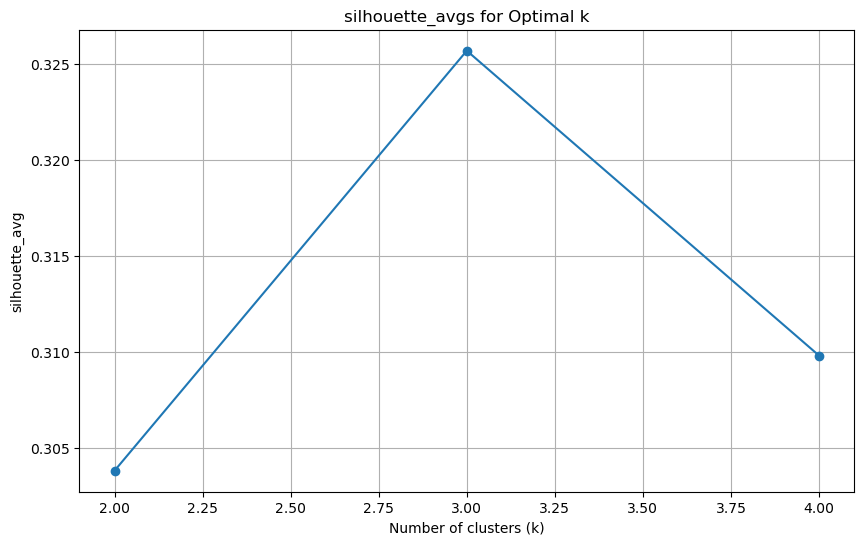

In [52]:
# determine the number of clusters using silhouette score
min_k, max_k = 2, 4
silhouette_list = []
for i in range(min_k, max_k+1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_reduced)
    pred = kmeans.predict(X_reduced)
    silhouette_avg = silhouette_score(X_reduced, pred)
    silhouette_list.append(silhouette_avg) 
    print(f"Number of clusters: {i}, Silhouette Score: {silhouette_avg:.4f}")

# Plotting silhouette scores for different k values
plt.figure(figsize=(10, 6))
plt.plot(range(min_k, max_k+1), silhouette_list, marker='o')
plt.title('silhouette_avgs for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('silhouette_avg')
plt.grid()
plt.show()

From the above chart we can determinate that k=3 would be the best choice. 

In [131]:
# Perform KMeans clustering with the optimal number of clusters
km = KMeans(n_clusters=3, random_state=42)
# Fit the model
km.fit(X_reduced)
# Predict the clusters
predictions = km.predict(X_reduced)
# Add predictions to the DataFrame
sample_reviews['cluster'] = predictions

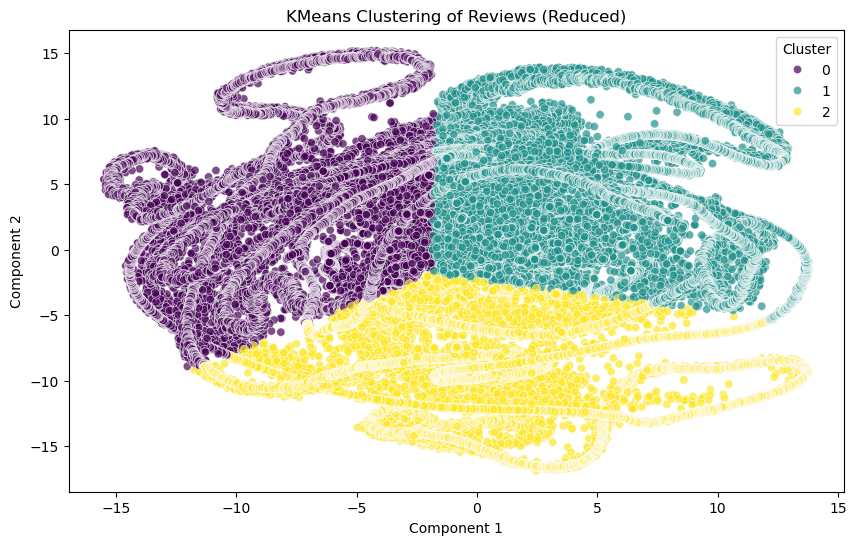

In [132]:
# Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=predictions, palette='viridis', alpha=0.7)
plt.title('KMeans Clustering of Reviews (Reduced)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Cluster')
plt.show()

/var/folders/qn/mj0rz2vn23nbzt4sm0qmhhtw0000gn/T/ipykernel_88619/3287251710.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/var/folders/qn/mj0rz2vn23nbzt4sm0qmhhtw0000gn/T/ipykernel_88619/3287251710.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/qn/mj0rz2vn23nbzt4sm0qmhhtw0000gn/T/ipykernel_88619/3287251710.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/qn/mj0rz2vn23nbzt4sm0qmhhtw0000gn/T/ipykernel_88619/3287251710.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_tic

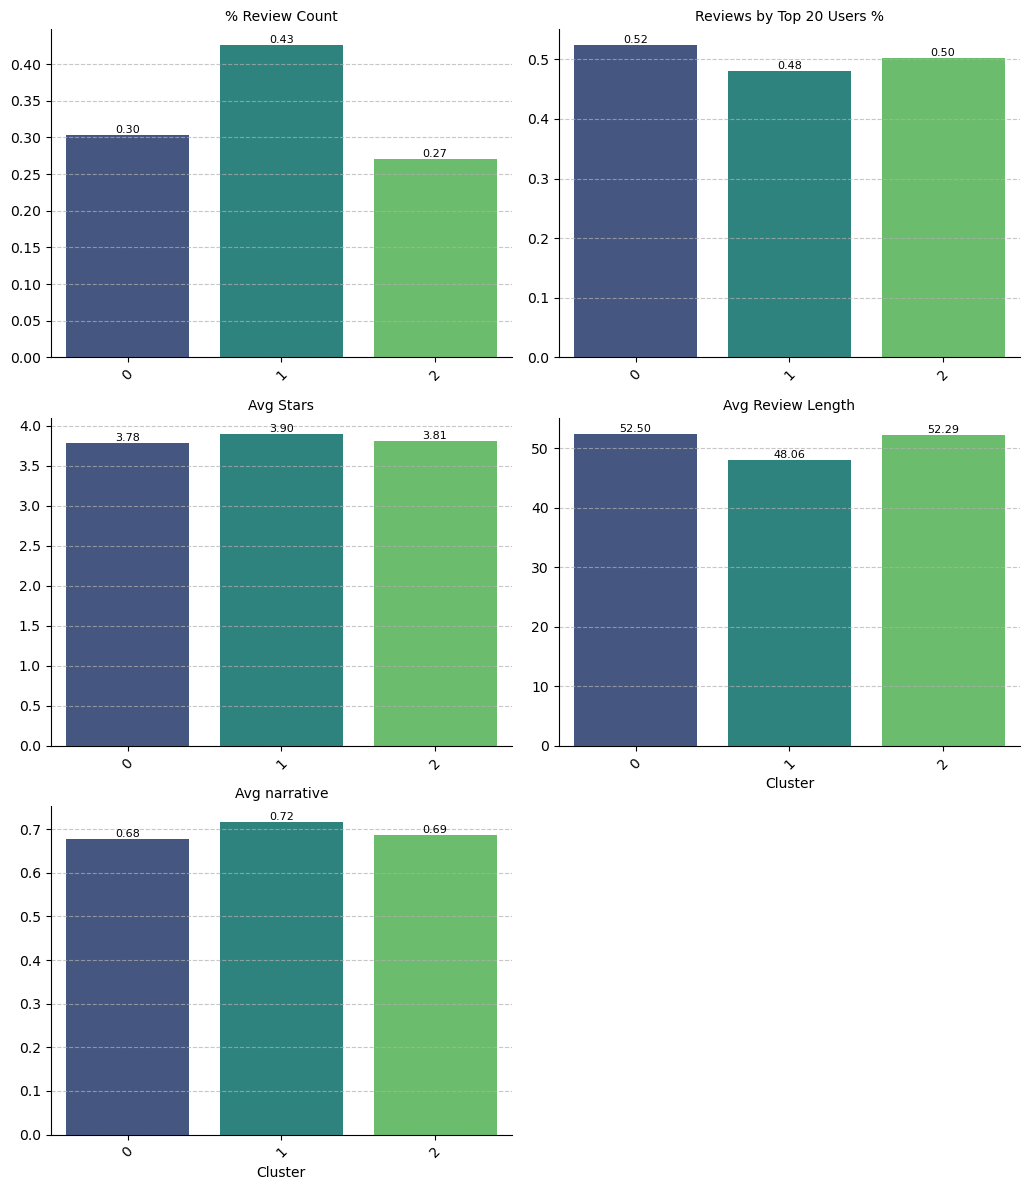

Summary by Cluster:
   cluster  % Review Count  Reviews by Top 20 Users %  Avg Stars  \
0        0        0.303315                   0.524208   3.784663   
1        1        0.426005                   0.481215   3.902137   
2        2        0.270680                   0.502438   3.809480   

   Avg Review Length  Avg narrative  
0          52.500783       0.677777  
1          48.057147       0.716482  
2          52.291008       0.686290  


In [133]:
# Ensure columns are numeric before analysis
for col in ['stars', 'review_length', 'narrative', 'useful', 'cool', 'funny', 'top_20']:
	if col in sample_reviews.columns:
		sample_reviews[col] = pd.to_numeric(sample_reviews[col], errors='coerce')

cluster_analysis_grouped(sample_reviews, 'cluster')

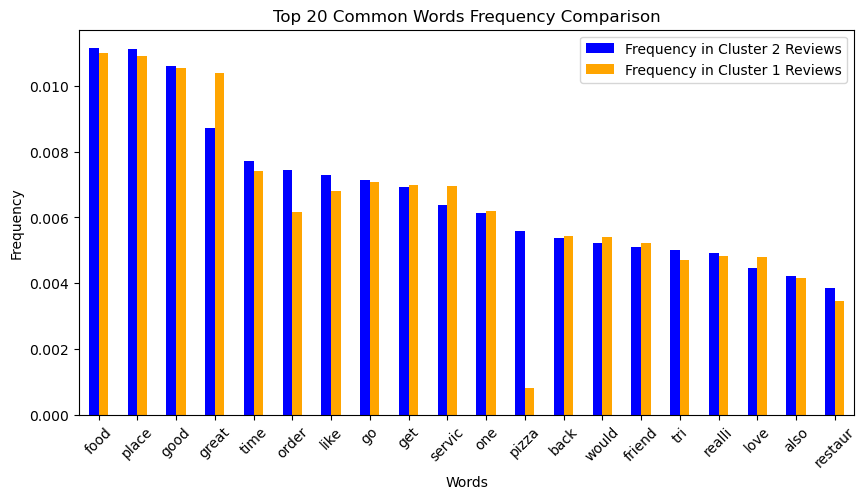

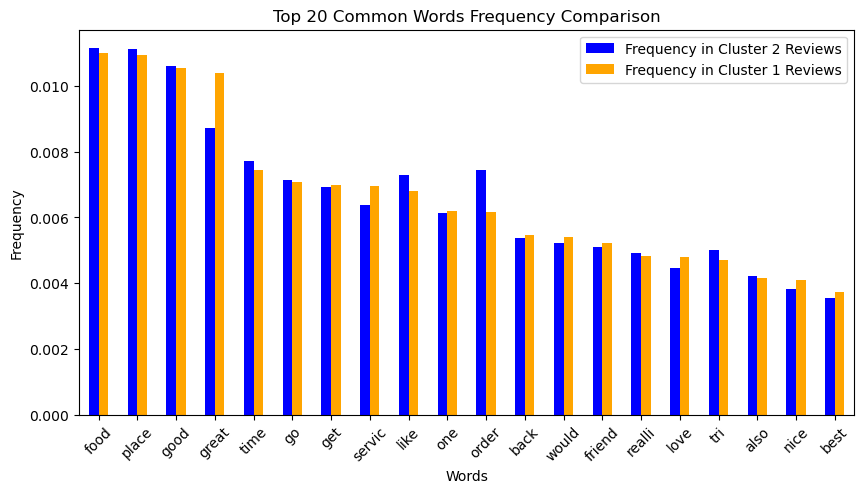

In [134]:
compare_words_frequency(
    ' '.join(sample_reviews[sample_reviews['cluster'] == 2]['text'].astype(str)),
    ' '.join(sample_reviews[sample_reviews['cluster'] == 1]['text'].astype(str)),
    'Cluster 2 Reviews',
    'Cluster 1 Reviews', max_words=20,
    sort_by_index=0
)
compare_words_frequency(
    ' '.join(sample_reviews[sample_reviews['cluster'] == 2]['text'].astype(str)),
    ' '.join(sample_reviews[sample_reviews['cluster'] == 1]['text'].astype(str)),
    'Cluster 2 Reviews',
    'Cluster 1 Reviews', max_words=20,
    sort_by_index=1
)

DBSCAN

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# נורמליזציה (לא חובה, אבל לפעמים עוזר)
X_scaled = MinMaxScaler().fit_transform(X_reduced)

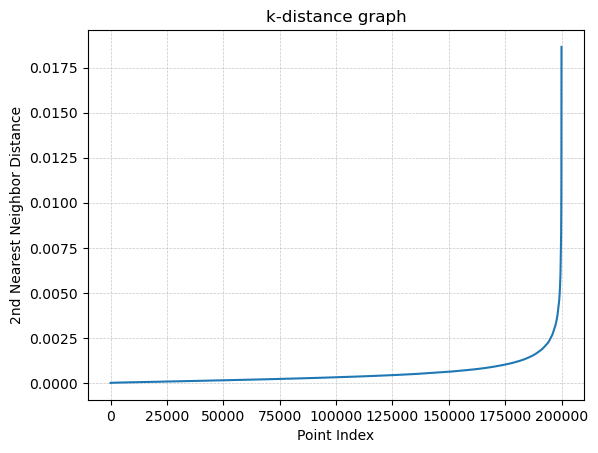

In [165]:
# usining nearest neighbors to find the optimal epsilon for DBSCAN
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort distances
distances = np.sort(distances[:, 1])
# trim the distances
distances = distances[distances < 0.02] 
plt.plot(distances)
plt.ylabel("2nd Nearest Neighbor Distance")
plt.xlabel("Point Index")
plt.title("k-distance graph")
plt.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)
#plt.axhline(y=0.5, color='r', linestyle='--', label='Epsilon Threshold')
plt.show()

In [1]:
dbs = DBSCAN(eps=0.03, min_samples=4) # (eps=0.017, min_samples=12) 
# Fit the model
dbs.fit(X_scaled)
# Predict the clusters
predictions = dbs.labels_
# Add predictions to the DataFrame
sample_reviews['cluster'] = predictions
# Calculate silhouette score only if there are at least 2 clusters (excluding noise)
n_clusters = len(set(predictions)) - (1 if -1 in predictions else 0)
if n_clusters > 1 and (predictions != -1).sum() > 1:
	silhouette_avg = silhouette_score(X[predictions != -1], predictions[predictions != -1])
	print(f"Silhouette Score for DBSCAN: {silhouette_avg:.4f}")
else:
	print("Silhouette Score for DBSCAN: Not applicable (less than 2 clusters found)")

#  visualization
"""
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=predictions, palette='viridis', alpha=0.7)
plt.title('DBSCAN Clustering of Reviews (Reduced)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')   
plt.legend(title='Cluster')
plt.show()
"""

print(f"Noise: {sample_reviews[sample_reviews['cluster'] == -1].shape[0]} reviews")
print(f"Noise Prc.: {sample_reviews[sample_reviews['cluster'] == -1].shape[0]/sample_reviews.shape[0] * 100}%")
print(f"Clusters: {len(set(predictions)) - (1 if -1 in predictions else 0)} clusters")

NameError: name 'DBSCAN' is not defined

/var/folders/qn/mj0rz2vn23nbzt4sm0qmhhtw0000gn/T/ipykernel_88619/3287251710.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/var/folders/qn/mj0rz2vn23nbzt4sm0qmhhtw0000gn/T/ipykernel_88619/3287251710.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/qn/mj0rz2vn23nbzt4sm0qmhhtw0000gn/T/ipykernel_88619/3287251710.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/qn/mj0rz2vn23nbzt4sm0qmhhtw0000gn/T/ipykernel_88619/3287251710.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_tic

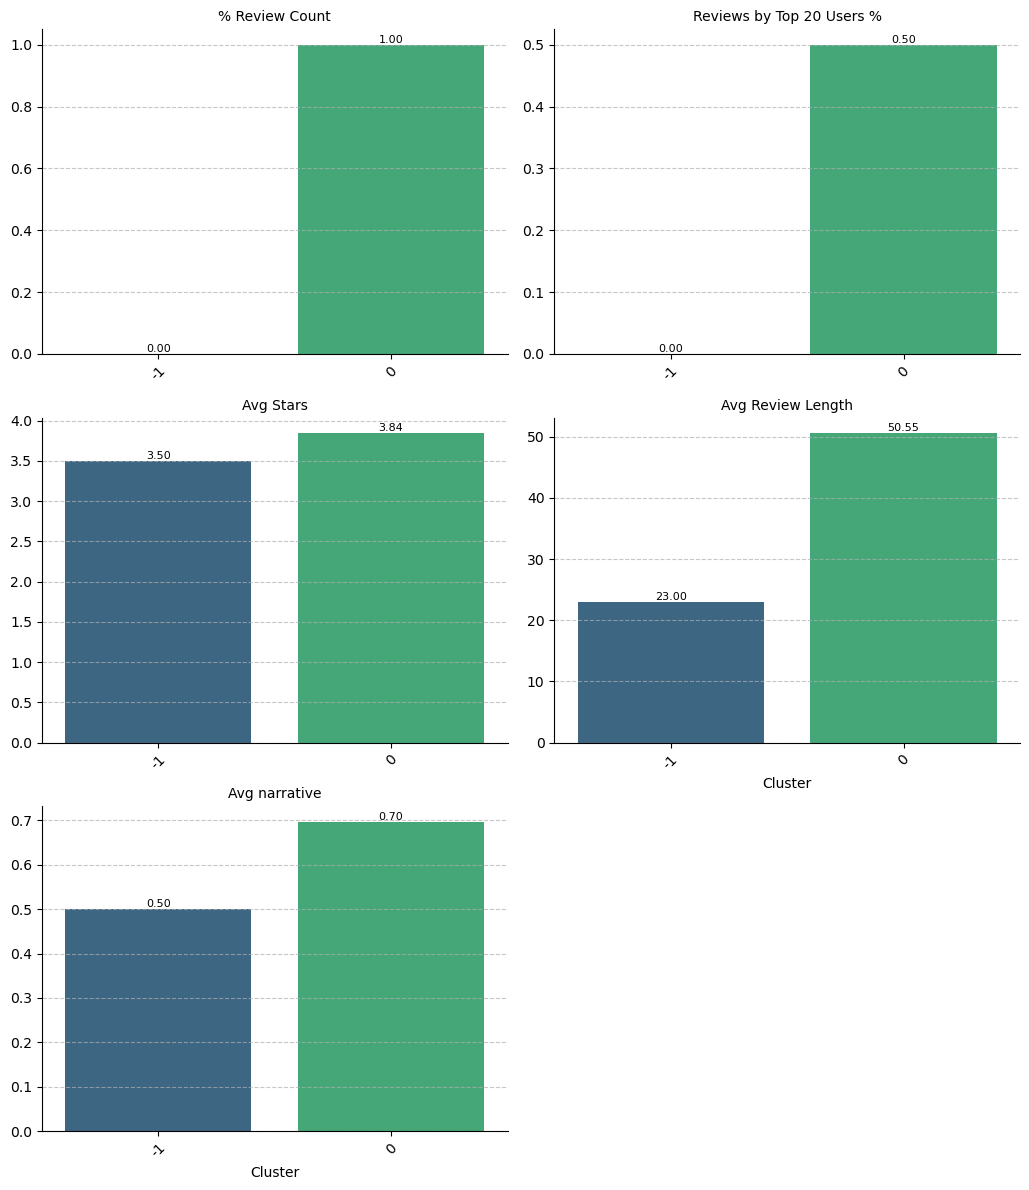

Summary by Cluster:
   cluster  % Review Count  Reviews by Top 20 Users %  Avg Stars  \
0       -1         0.00001                   0.000000   3.500000   
1        0         0.99999                   0.500005   3.841428   

   Avg Review Length  Avg narrative  
0          23.000000       0.500000  
1          50.551266       0.696572  


In [162]:
cluster_analysis_grouped(sample_reviews, 'cluster')

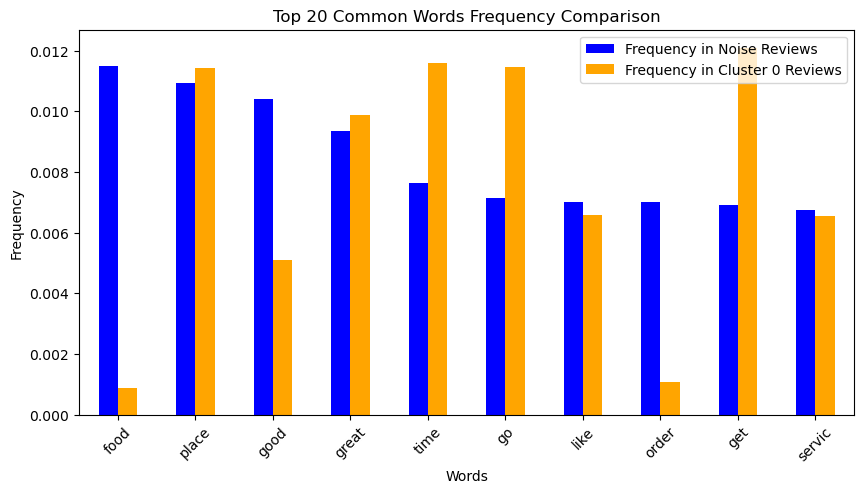

In [59]:
#create_wordcloud(' '.join(sample_reviews[sample_reviews['cluster'] == -1]['text'].astype(str)), "Noise Word Cloud", max_words=7)
compare_words_frequency(
    ' '.join(sample_reviews[sample_reviews['cluster'] == -1]['text'].astype(str)),
    ' '.join(sample_reviews[sample_reviews['cluster'] == 0]['text'].astype(str)),
    'Noise Reviews',
    'Cluster 0 Reviews', max_words=10, sort_by_index=0
)

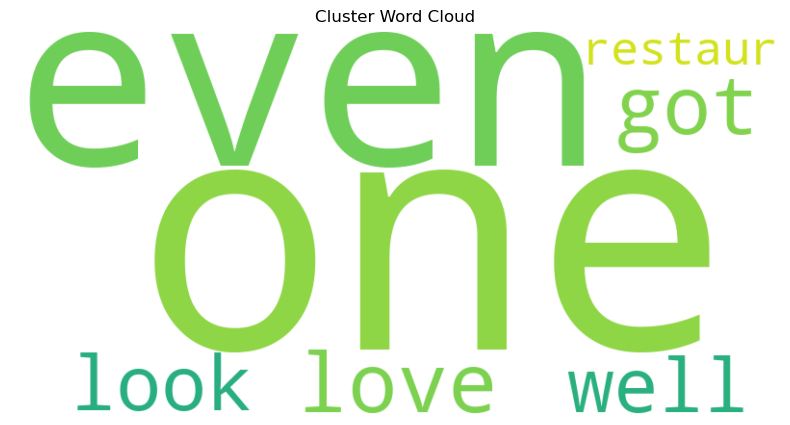

: 

In [ ]:
create_wordcloud(' '.join(sample_reviews[sample_reviews['cluster'] != -1]['text'].astype(str)), "Cluster Word Cloud", max_words=7)


In [ ]:
# plot the hierarchical clustering dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(X_reduced, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=predictions, distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [ ]:
hr = AgglomerativeClustering(n_clusters=8)
# Fit the model
hr.fit(X_reduced)  # Convert sparse matrix to dense for hierarchical clustering
# Predict the clusters
predictions = hr.labels_
# Add predictions to the DataFrame
sample_reviews['cluster'] = predictions
# Calculate silhouette score
silhouette_avg = silhouette_score(X_reduced, predictions)
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_avg:.4f}")

#  visualization

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_reduced_plt[:, 0], y=X_reduced_plt[:, 1], hue=predictions, palette='viridis', alpha=0.7)
plt.title('Hierarchical Clustering of Reviews (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [ ]:
compare_words_frequency(
    ' '.join(sample_reviews[sample_reviews['cluster'] == 0]['text'].astype(str)),
    ' '.join(sample_reviews[sample_reviews['cluster'] == 1]['text'].astype(str)),
    'Cluster 0 Reviews',
    'Cluster 1 Reviews', max_words=20,
    sort_by_index=0
)

In [ ]:
cluster_analysis_grouped(sample_reviews, 'cluster')